In [47]:
import numpy as np
from skimage.io import imread, imsave
from skimage.measure import label, regionprops
from skimage.util import invert
from scipy.sparse import csr_matrix,lil_matrix,coo_matrix
from scipy.linalg import eigh, inv, logm, norm
from  scipy import ndimage,sparse
import cv2
import os
import sys
import csv
import glob

import h5py
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import skimage.io
import skimage.measure
import skimage.color
from skimage import exposure, img_as_ubyte

import tifffile
import random

In [48]:
#csv_file = '../pkl/csv/id_13.fov_centroids_embedding_morphology.covd.pkl.csv'
csv_file = '../pkl/id_13.fov_centroids_embedding_morphology.covd.pkl.csv'
df = pd.read_csv(csv_file)

46 41
8 27
9 36
6 30
13 17
2 7
38 42
17 33
30 35
40 29


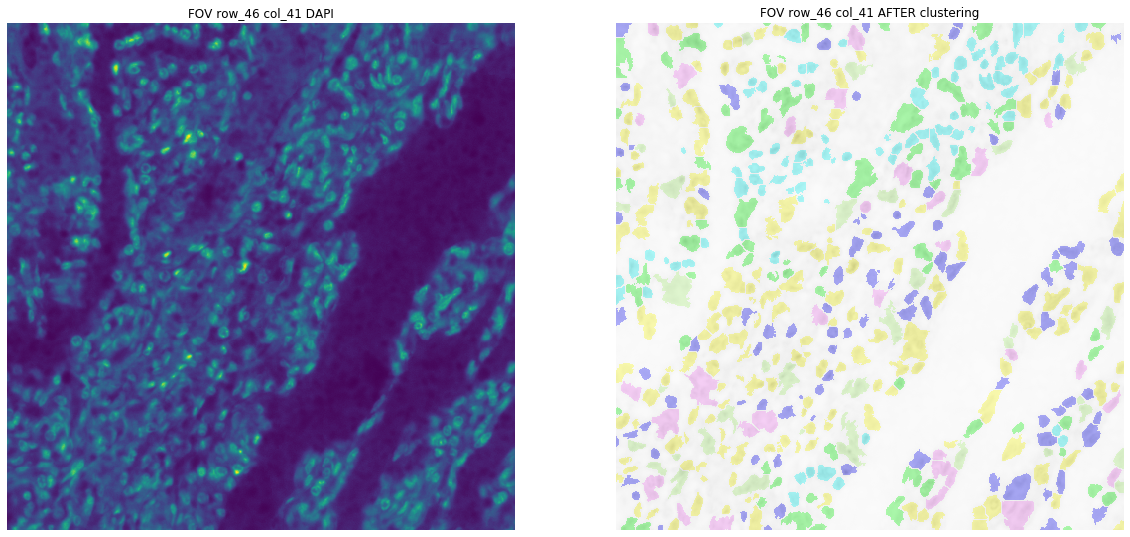

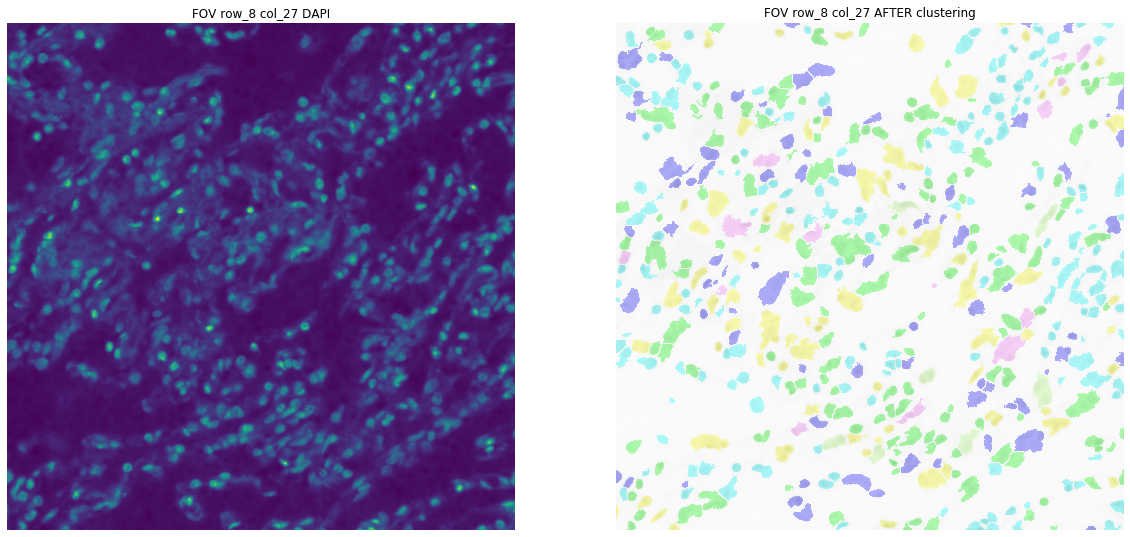

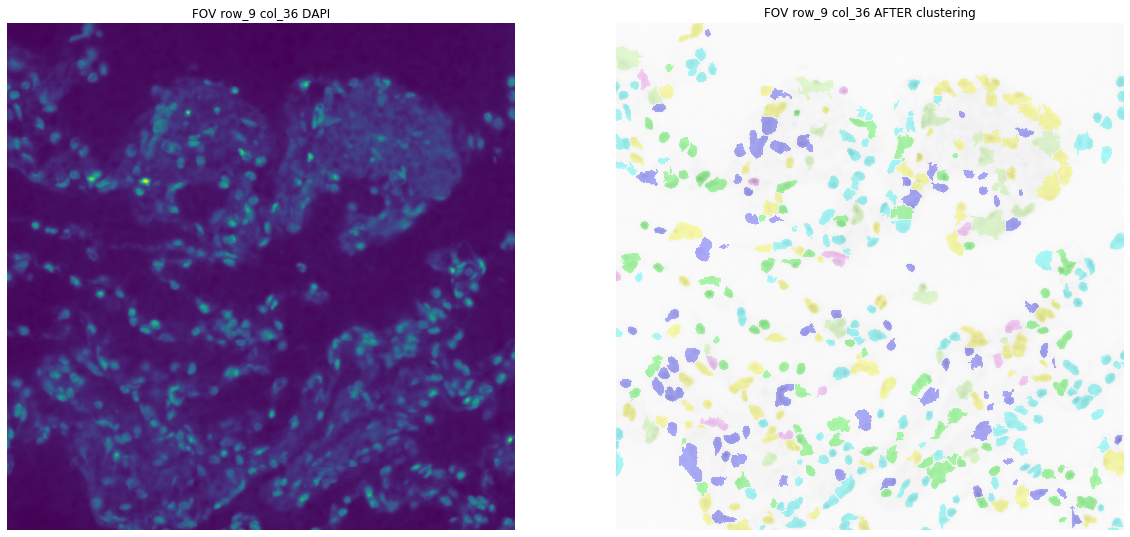

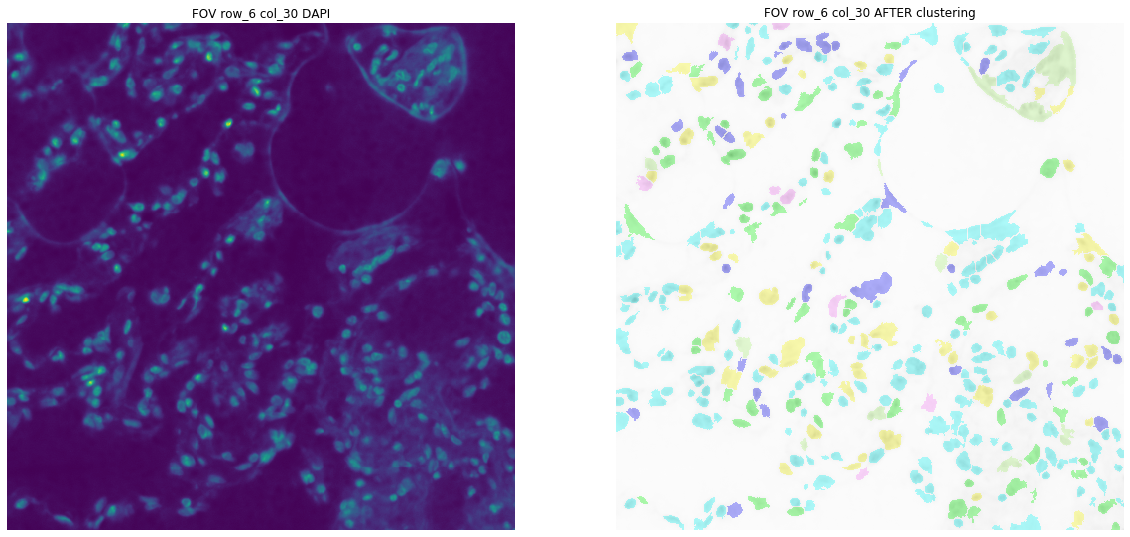

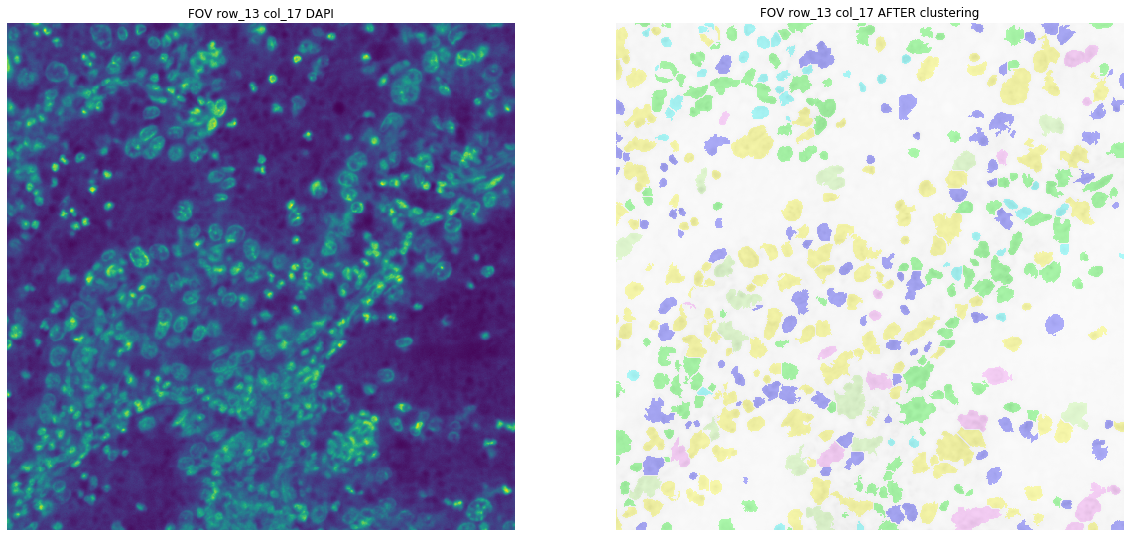

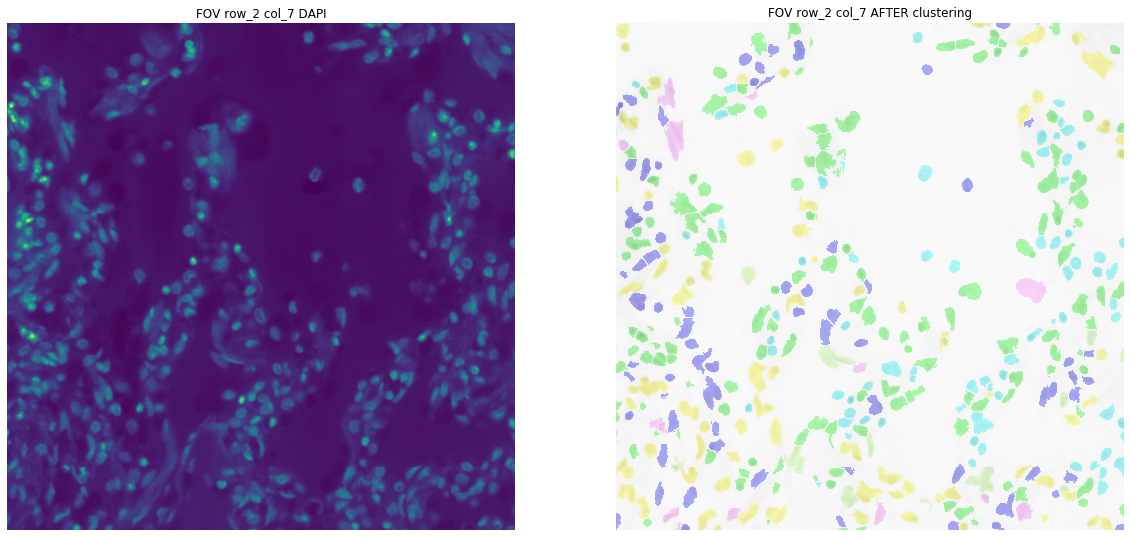

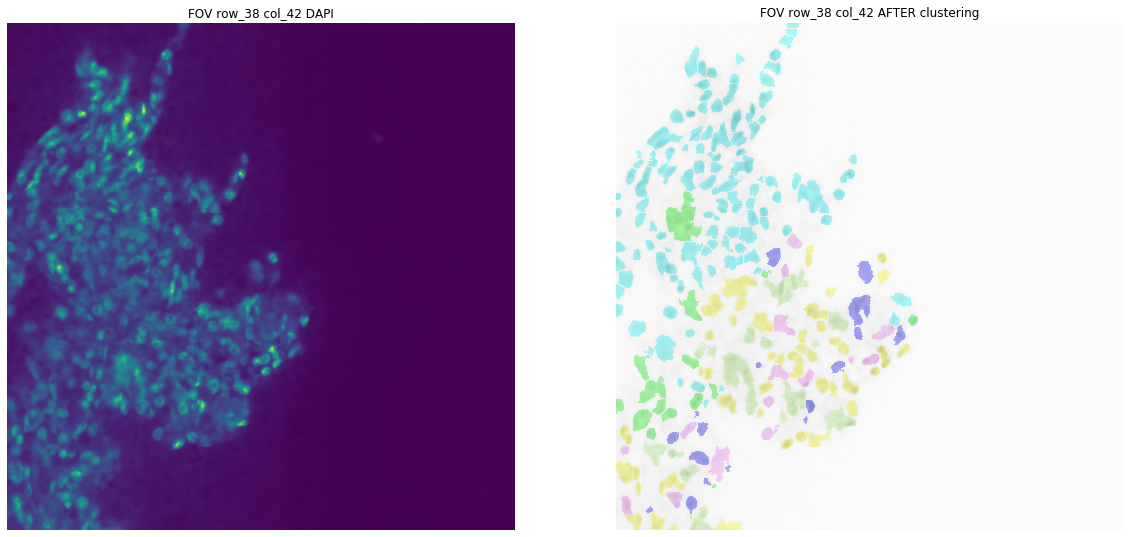

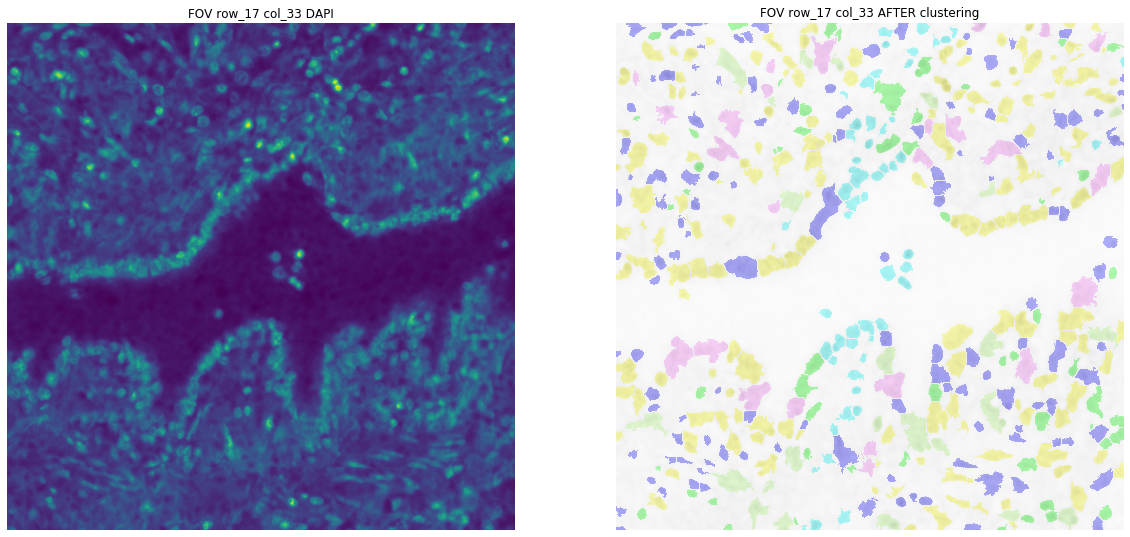

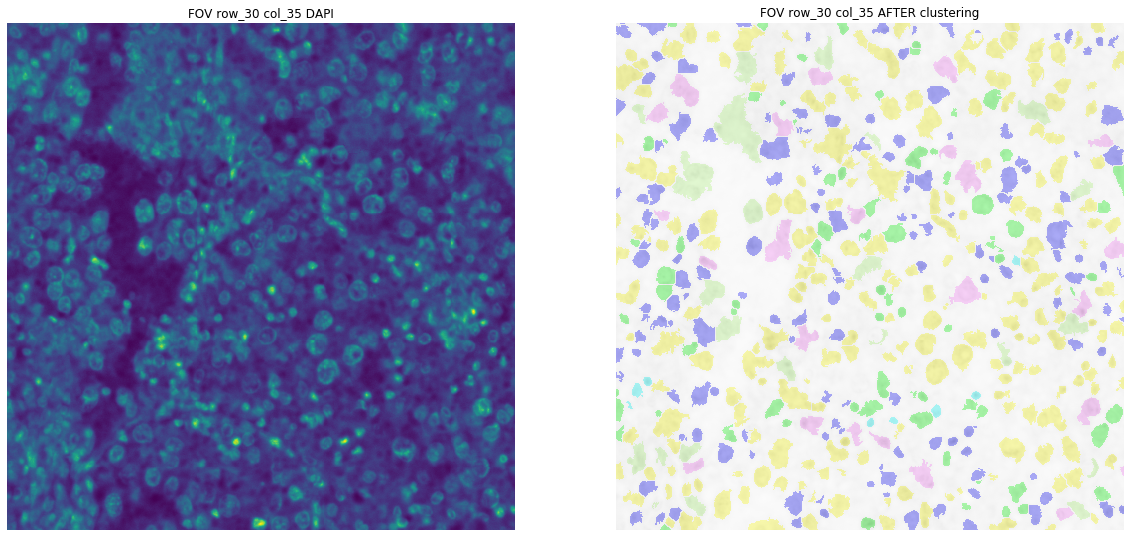

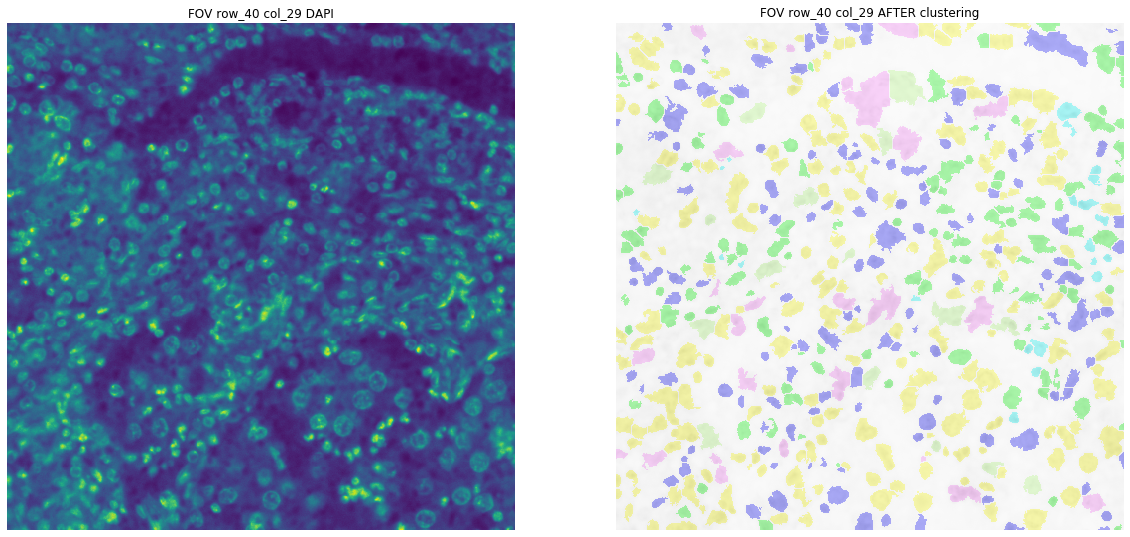

In [49]:
rc_df = df.groupby(['fov_row','fov_col']).size().reset_index().rename(columns={0:'count'}) # the df of row-col fov pairs
for row, col in random.choices(list(zip(rc_df.fov_row, rc_df.fov_col)),k=10):
    print(row,col)
    df_fov = df.loc[(df['fov_row'] == row) & (df['fov_col'] == col)]

    # load the h5 file
    h5_file = '../h5/id_13/iMS342_20190715_001._r'+str(row)+'_c'+str(col)+'.h5'   #this file contains the segmented nuclei                                                                                                                    
    fov = h5py.File(h5_file, 'r') # load the current fov segmentation                                                                                                                   
    mask = fov['/exported_watershed_masks'][:]
    mask_reduced = np.squeeze(mask, axis=2) #to get rid of the third dimension                                                                                                          
    mask_label, numb_of_nuclei = label(mask_reduced,return_num=True) # to define the mask_label array
    
    # load dapi file
    basename = os.path.splitext(h5_file)[0]
    dapi_file = basename+'.tif' # the dapi file has to be located in the same directory as the h5 file                                                                                  
    dapi_fov= np.squeeze(imread(dapi_file)) #the dapi tif file of the current FOV                                                                                          
    # define new_mask_label associated to clusters
    new_mask_label = np.zeros((512,512))
    for index, nuclei in df_fov.iterrows(): # for each nucleus in csv in fov
        cx = nuclei['cx'] # read the centroid x coordinate
        cy = nuclei['cy'] # read the centroid y coordinate
        cluster = int(nuclei['cluster']) # read the cluster label
        for region in regionprops(mask_label,intensity_image=dapi_fov): # for each nucleus in fov
            #if a region is too small or too large do not consider it
            x = 512*int(col)+region.centroid[0] # shift by FOV location                                                                                                                 
            y = 512*int(row)+region.centroid[1] # shift by FOV location                                                                                                                 
            if abs(x - cx) < 1.0E-6 and abs(y - cy) < 1.0E-6: # tolerate some error in the coordinate values
                # find location in mask_label where label is equal to region.label
                # sum 1 to make unclustered nuclei equal to bg_label 0
                new_mask_label[mask_label == region.label] = cluster + 1 
    
    cluster_label = np.rot90(np.fliplr(new_mask_label)) # flip and rotate to match dapi 
    fig = plt.figure(figsize=(20, 10))
    # show pre-clustering figure
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(dapi_fov,origin='lower')
    ax1.set_title('FOV row_'+str(row)+' col_'+str(col)+' DAPI')
    ax1.axis('off')
    # show post-clustering figure
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(invert(skimage.color.label2rgb(cluster_label, dapi_fov, bg_label=0)),origin='lower')
    ax2.set_title('FOV row_'+str(row)+' col_'+str(col)+' AFTER clustering')
    ax2.axis('off')
    # save images as png file
    plt.savefig(basename+'.dapi-clustering.png')
    # save dapi and clusters as tiff file    
    dapi_uint8 = img_as_ubyte(exposure.rescale_intensity(dapi_fov)) # convert to uint8 to save as tiff file
    tensor = np.zeros((len(np.unique(df.cluster))+1,512,512),dtype=np.uint8) # +1 for dapi channel
    tensor[0,:,:] = dapi_uint8 # dapi channel
    for label_idx in range(1,tensor.shape[0]): # for each cluster
        array_2d = np.zeros((512,512)).astype(np.uint8)
        array_2d[cluster_label == label_idx] = 1 
        tensor[label_idx,:,:] = array_2d # save the channel
    with tifffile.TiffWriter(basename+'.ome.tiff', imagej=True) as tif:
        tif.save(tensor)